In [1]:
import sys
sys.path.append('/Users/exwong/github/exlib/src')
import exlib

In [2]:
import torch
import torch.nn.functional as F
from exlib.datasets.massmaps import MassMaps, MassMapsConvnet

batch_size = 5
DATA_DIR = "./data/"

test_dataset = MassMaps(DATA_DIR, 
                        split='test')
loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
model = MassMapsConvnet(DATA_DIR)

In [3]:
for X,y in loader:
    X,y = X.float(), y.float()
    out = model(X)
    loss = F.mse_loss(out, y)
    print(out, y, loss)
    break

tensor([[0.1918, 0.9656],
        [0.1325, 1.1280],
        [0.2478, 0.5533],
        [0.3206, 0.7607],
        [0.0986, 1.1717]], grad_fn=<AddmmBackward0>) tensor([[0.1846, 0.9884],
        [0.1037, 1.1905],
        [0.2908, 0.4728],
        [0.2787, 0.7530],
        [0.1245, 1.1571]]) tensor(0.0016, grad_fn=<MseLossBackward0>)


In [6]:
from exlib.explainers.torch_explainer import TorchLime
from exlib.explainers.common import patch_segmenter
from exlib.evaluators.attributions import NNZ


eik = {
    "segmentation_fn": patch_segmenter,
    "top_labels": 5, 
    "hide_color": 0, 
    "num_samples": 1000
}
gimk = {
    "positive_only": False
}
explainer = TorchLime(model, 
                      explain_instance_kwargs=eik, 
                      get_image_and_mask_kwargs=gimk)
evaluator = NNZ()
expln = explainer(X)
evaluator(X,expln.attributions, normalize=True)

100%|███████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1825.35it/s]


tensor([0.0829, 0.0771, 0.0753, 0.0771, 0.0790])

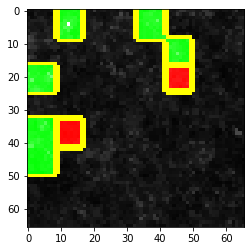

In [5]:
from skimage.segmentation import mark_boundaries
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

explanation = expln.explainer_output[0]

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=8, hide_rest=False)
X_min, X_max = temp.min(), temp.max()
img_boundry1 = mark_boundaries((temp-X_min)/(X_max-X_min), mask)
plt.imshow(img_boundry1, vmin=0, vmax=1, cmap='bwr')